In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sunRay.parameters import c,c_r,R_S  # physics parameters
from scipy import integrate

In [2]:
data  = np.load('sunray_big_float32_20deg.npz')

In [3]:
absorb_r = (np.count_nonzero((np.isnan(data.f.r_vec_collect_local[-1,1,:]))))/data.f.photon_N

In [4]:
# retrive the data from archive
steps_N  =data.f.steps_N
collect_N =data.f.collect_N
photon_N =data.f.photon_N
start_r =data.f.start_r
start_theta =data.f.start_theta
start_phi  =data.f.start_phi
f_ratio  =data.f.f_ratio
epsilon =data.f.epsilon 
anis =data.f.anis
asym =data.f.asym
omega0 = data.f.omega0
freq0 = data.f.freq0
t_collect=data.f.t_collect
tau=data.f.tau
r_vec_collect_local=data.f.r_vec_collect_local
k_vec_collect_local=data.f.k_vec_collect_local

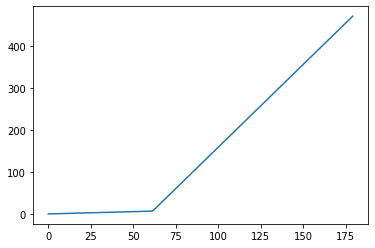

In [5]:
plt.plot(t_collect)

In [6]:
absorb_r

0.269757

In [7]:
from sunRay.statisticalRays import collectXYt1AU

(x_im_stat,y_im_stat,t_reach_stat,weights_stat) = collectXYt1AU(photon_N,r_vec_collect_local,k_vec_collect_local,t_collect,tau,omega0)

In [8]:
%load_ext autoreload
%autoreload 2

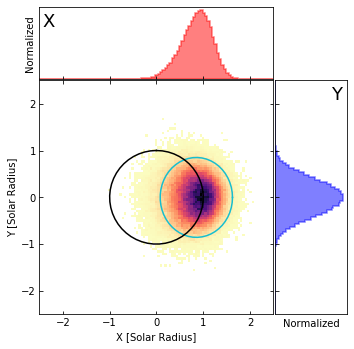

In [9]:
#hst = plt.hist2d(x_im_stat,y_im_stat,bins=[np.linspace(-2,2,100),np.linspace(-2,2,100)],weights=np.exp(-tau_stat))
#plt.axis('equal')


from sunRay.showPlot import XYDistributionImageHist

XYDistributionImageHist(x_im_stat,y_im_stat,bins_data=np.linspace(-2.5,2.5,100)
            ,weights_data=weights_stat)

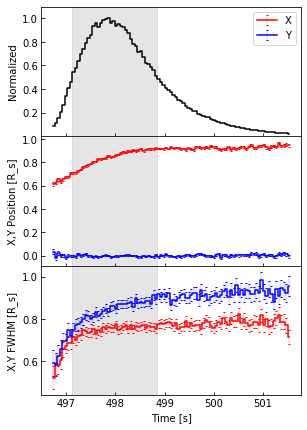

In [10]:
from sunRay.showPlot import XYVariationPlot

XYVariationPlot(x_im_stat,y_im_stat,t_reach_stat,weights_stat,t_step = 0.02)

In [27]:
hst = plt.hist(t_reach_1au_stat,150,weights=np.exp(-tau_stat))


In [47]:
215/c_r

499.13275517011346

In [145]:
print(hst[0][20,:])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.22065742e-01 0.00000000e+00 4.40566029e-01 1.70077755e+00
 1.70748397e+00 6.95538646e+00 5.89382475e+00 9.85790884e+00
 1.26816283e+01 2.18808190e+01 2.89920703e+01 4.33193431e+01
 6.20829333e+01 6.96648978e+01 8.87157899e+01 8.75351301e+01
 1.02120347e+02 1.11840275e+02 1.07779498e+02 1.13492928e+02
 1.17933382e+02 1.16222340e+02 1.07980399e+02 9.12755591e+01
 8.95812356e+01 8.26491111e+01 7.54039651e+01 5.97456903e+01
 4.14483934e+01 3.11447867e+01 2.23753065e+01 1.72361751e+01
 1.14423529e+01 2.51488231e+00 1.75856313e+00 1.58451947e+00
 4.89390125e-01 7.68808850e-01 2.72333048e-01 0.00000000e+00
 1.13675706e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.60123366e-01 0.00000000e+00]


In [88]:
x_im_stat.shape
# finish time diff based 
# fit guassian

(217062,)

In [19]:
t_collect[-1]

470.14267